In [1]:
from heston import simulate
from datetime import date, timedelta
import matplotlib.pyplot as plt
plt.style.use('dark_background')

[*********************100%***********************]  1 of 1 completed
/Users/viviankessler/stock-sde/heston.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  times = torch.tensor(observed_process["t"], requires_grad=False)
/Users/viviankessler/stock-sde/heston.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_states = torch.tensor(observed_process[["S", "ν"]].iloc[0], requires_grad=False).repeat(num_simulations, 1)
/Users/viviankessler/stock-sde/heston.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is ca

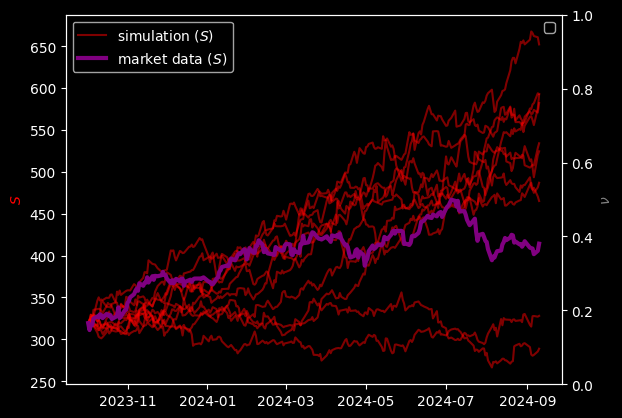

In [2]:
stock_name = "MSFT"
simulation = simulate(
    stock_name=stock_name,
    start=date.today() - timedelta(days=360),
    end=date.today(),
    interval="1d",
    local_vol_window_size=5,
    plot=True
)